# Time Matching between Collection and Induction Plane

Finding the difference in time ticks on average for the same track between collection and induction plane.

In [1]:
import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

In [2]:
indices = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/indicies_v1_c30_i30.csv')

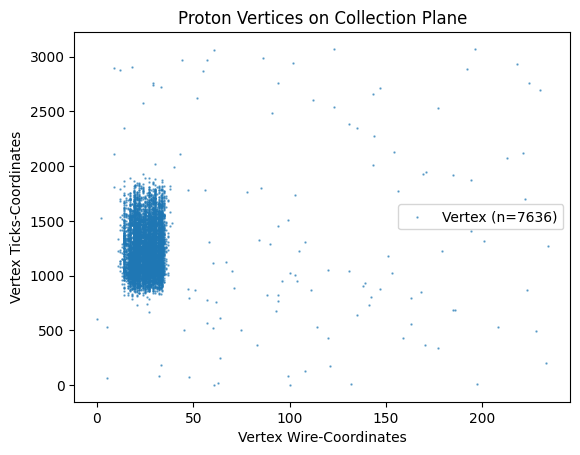

In [3]:
col_wire = np.array(indices['col_wire'].values)
col_time = np.array(indices['col_time'].values)

plt.figure()
plt.scatter(col_wire, col_time, s=0.5, alpha=0.6, label=f'Vertex (n={len(col_wire)})')
plt.xlabel('Vertex Wire-Coordinates')
plt.ylabel('Vertex Ticks-Coordinates')
plt.title('Proton Vertices on Collection Plane')
plt.legend()
plt.show()

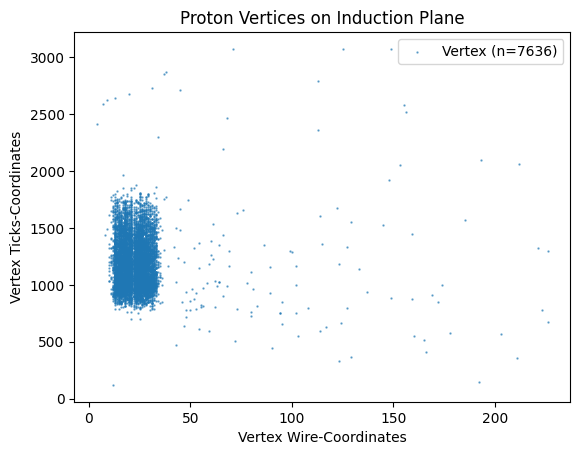

In [4]:
ind_wire = np.array(indices['ind_wire'].values)
ind_time = np.array(indices['ind_time'].values)

plt.figure()
plt.scatter(ind_wire, ind_time, s=0.5, alpha=0.6, label=f'Vertex (n={len(col_wire)})')
plt.xlabel('Vertex Wire-Coordinates')
plt.ylabel('Vertex Ticks-Coordinates')
plt.title('Proton Vertices on Induction Plane')
plt.legend()
plt.show()

In [5]:
def find_cluster_bounds(wire_coords, time_coords):
    """Find bounds of main cluster using percentiles"""
    # Filter out extreme outliers first
    wire_p5, wire_p95 = np.percentile(wire_coords, [10, 90]) # visually tuned
    time_p5, time_p95 = np.percentile(time_coords, [10, 90])
    
    # Mask for main cluster
    mask = ((wire_coords >= wire_p5) & (wire_coords <= wire_p95) & 
            (time_coords >= time_p5) & (time_coords <= time_p95))
    
    # Bounds of main cluster
    wire_min, wire_max = wire_coords[mask].min(), wire_coords[mask].max()
    time_min, time_max = time_coords[mask].min(), time_coords[mask].max()
    
    return wire_min, wire_max, time_min, time_max

cwire_min, cwire_max, ctime_min, ctime_max = find_cluster_bounds(col_wire, col_time)
iwire_min, iwire_max, itime_min, itime_max = find_cluster_bounds(ind_wire, ind_time)
print(f"Main cluster bounds: Wire [{cwire_min}, {cwire_max}], Time [{ctime_min}, {ctime_max}]")
print(f"Main cluster bounds: Wire [{iwire_min}, {iwire_max}], Time [{itime_min}, {itime_max}]")

Main cluster bounds: Wire [17, 33], Time [985, 1557]
Main cluster bounds: Wire [15, 31], Time [942, 1509]


In [8]:
cwire_min, cwire_max, ctime_min, ctime_max = find_cluster_bounds(col_wire, col_time)
iwire_min, iwire_max, itime_min, itime_max = find_cluster_bounds(ind_wire, ind_time)
print(f"Collection cluster bounds: Wire [{cwire_min}, {cwire_max}], Time [{ctime_min}, {ctime_max}]")
print(f"Induction cluster bounds: Wire [{iwire_min}, {iwire_max}], Time [{itime_min}, {itime_max}]")

# Use bounds from both planes for filtering
col_time_mask = (indices['col_time'] >= ctime_min) & (indices['col_time'] <= ctime_max)
col_wire_mask = (indices['col_wire'] >= cwire_min) & (indices['col_wire'] <= cwire_max)
ind_time_mask = (indices['ind_time'] >= itime_min) & (indices['ind_time'] <= itime_max)
ind_wire_mask = (indices['ind_wire'] >= iwire_min) & (indices['ind_wire'] <= iwire_max)

# Apply all four masks
combined_mask = col_time_mask & col_wire_mask & ind_time_mask & ind_wire_mask
filtered_indices = indices[combined_mask].copy()

print(f"\nOriginal data points: {len(indices)}")
print(f"Collection time mask: {len(indices[col_time_mask])}")
print(f"Collection wire mask: {len(indices[col_wire_mask])}")
print(f"Induction time mask: {len(indices[ind_time_mask])}")
print(f"Induction wire mask: {len(indices[ind_wire_mask])}")
print(f"All masks applied: {len(filtered_indices)}")
print(f"Percentage retained: {len(filtered_indices)/len(indices)*100:.1f}%")

# Extract filtered coordinates
col_wire_filtered = np.array(filtered_indices['col_wire'].values)
col_time_filtered = np.array(filtered_indices['col_time'].values)
ind_wire_filtered = np.array(filtered_indices['ind_wire'].values)
ind_time_filtered = np.array(filtered_indices['ind_time'].values)

print(f"\nFiltered ranges:")
print(f"Collection wire range: [{col_wire_filtered.min()}, {col_wire_filtered.max()}]")
print(f"Collection time range: [{col_time_filtered.min()}, {col_time_filtered.max()}]")
print(f"Induction wire range: [{ind_wire_filtered.min()}, {ind_wire_filtered.max()}]")
print(f"Induction time range: [{ind_time_filtered.min()}, {ind_time_filtered.max()}]")

Collection cluster bounds: Wire [17, 33], Time [985, 1557]
Induction cluster bounds: Wire [15, 31], Time [942, 1509]

Original data points: 7636
Collection time mask: 6115
Collection wire mask: 6604
Induction time mask: 6115
Induction wire mask: 6417
All masks applied: 4978
Percentage retained: 65.2%

Filtered ranges:
Collection wire range: [17, 33]
Collection time range: [985, 1555]
Induction wire range: [15, 31]
Induction time range: [942, 1509]


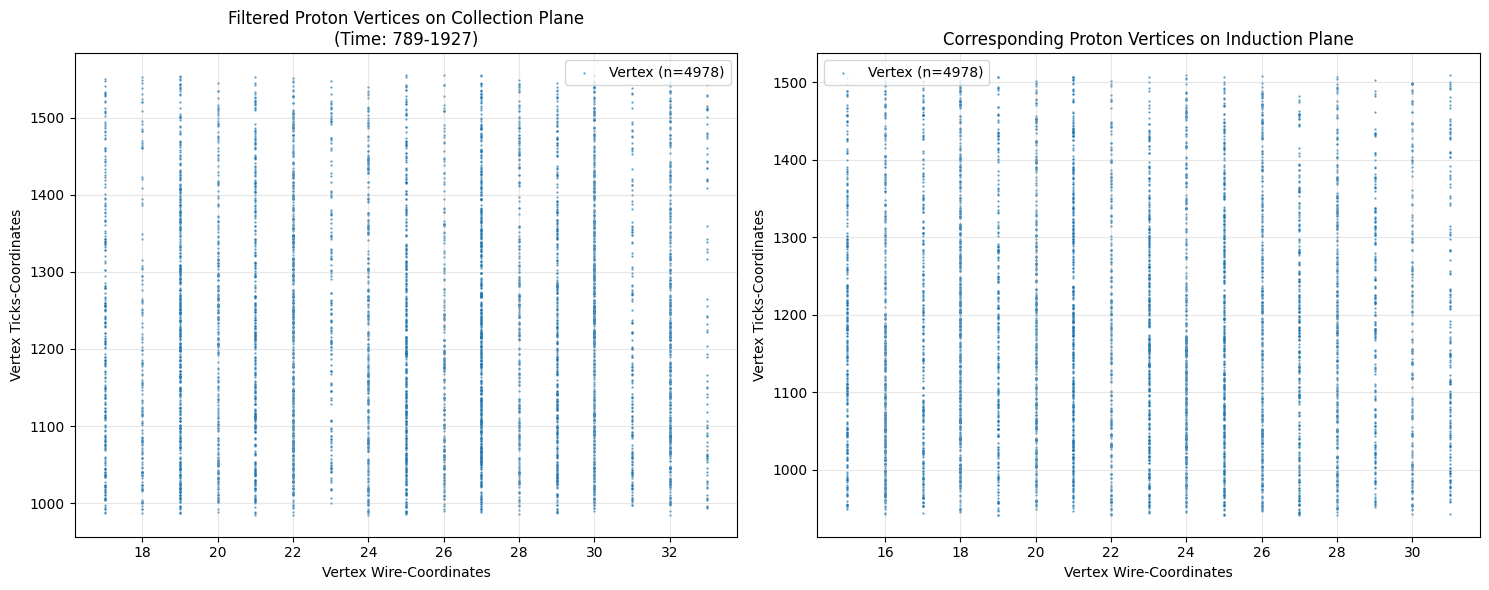

In [9]:
# Plot filtered data
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Collection plane scatter plot
axes[0].scatter(col_wire_filtered, col_time_filtered, s=0.5, alpha=0.6, 
                label=f'Vertex (n={len(col_wire_filtered)})')
axes[0].set_xlabel('Vertex Wire-Coordinates')
axes[0].set_ylabel('Vertex Ticks-Coordinates')
axes[0].set_title('Filtered Proton Vertices on Collection Plane\n(Time: 789-1927)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Induction plane scatter plot
axes[1].scatter(ind_wire_filtered, ind_time_filtered, s=0.5, alpha=0.6, 
                label=f'Vertex (n={len(ind_wire_filtered)})')
axes[1].set_xlabel('Vertex Wire-Coordinates')
axes[1].set_ylabel('Vertex Ticks-Coordinates')
axes[1].set_title('Corresponding Proton Vertices on Induction Plane')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Calculate time coordinate differences for filtered data
time_diff_filtered = col_time_filtered - ind_time_filtered

# Calculate statistics for filtered data
stats_filtered = {
    'mean_diff': np.mean(time_diff_filtered),
    'std_diff': np.std(time_diff_filtered),
    'median_diff': np.median(time_diff_filtered),
    'min_diff': np.min(time_diff_filtered),
    'max_diff': np.max(time_diff_filtered),
    'q25_diff': np.percentile(time_diff_filtered, 25),
    'q75_diff': np.percentile(time_diff_filtered, 75),
    'iqr': np.percentile(time_diff_filtered, 75) - np.percentile(time_diff_filtered, 25)
}

print("Time Coordinate Differences (Collection - Induction) - Filtered Data:")
print(f"Mean: {stats_filtered['mean_diff']:.2f}")
print(f"Std Dev: {stats_filtered['std_diff']:.2f}")
print(f"Median: {stats_filtered['median_diff']:.2f}")
print(f"Min: {stats_filtered['min_diff']:.2f}")
print(f"Max: {stats_filtered['max_diff']:.2f}")
print(f"25th percentile: {stats_filtered['q25_diff']:.2f}")
print(f"75th percentile: {stats_filtered['q75_diff']:.2f}")
print(f"IQR: {stats_filtered['iqr']:.2f}")
print(f"Number of points: {len(time_diff_filtered)}")

Time Coordinate Differences (Collection - Induction) - Filtered Data:
Mean: 44.14
Std Dev: 11.85
Median: 43.00
Min: -37.00
Max: 127.00
25th percentile: 35.00
75th percentile: 52.00
IQR: 17.00
Number of points: 4978


/var/folders/cm/m55y72dj6cd5lkwrfdb2bpnr0000gp/T/ipykernel_11113/4027311927.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(box_data_filtered, labels=['Collection', 'Induction', 'Difference'],


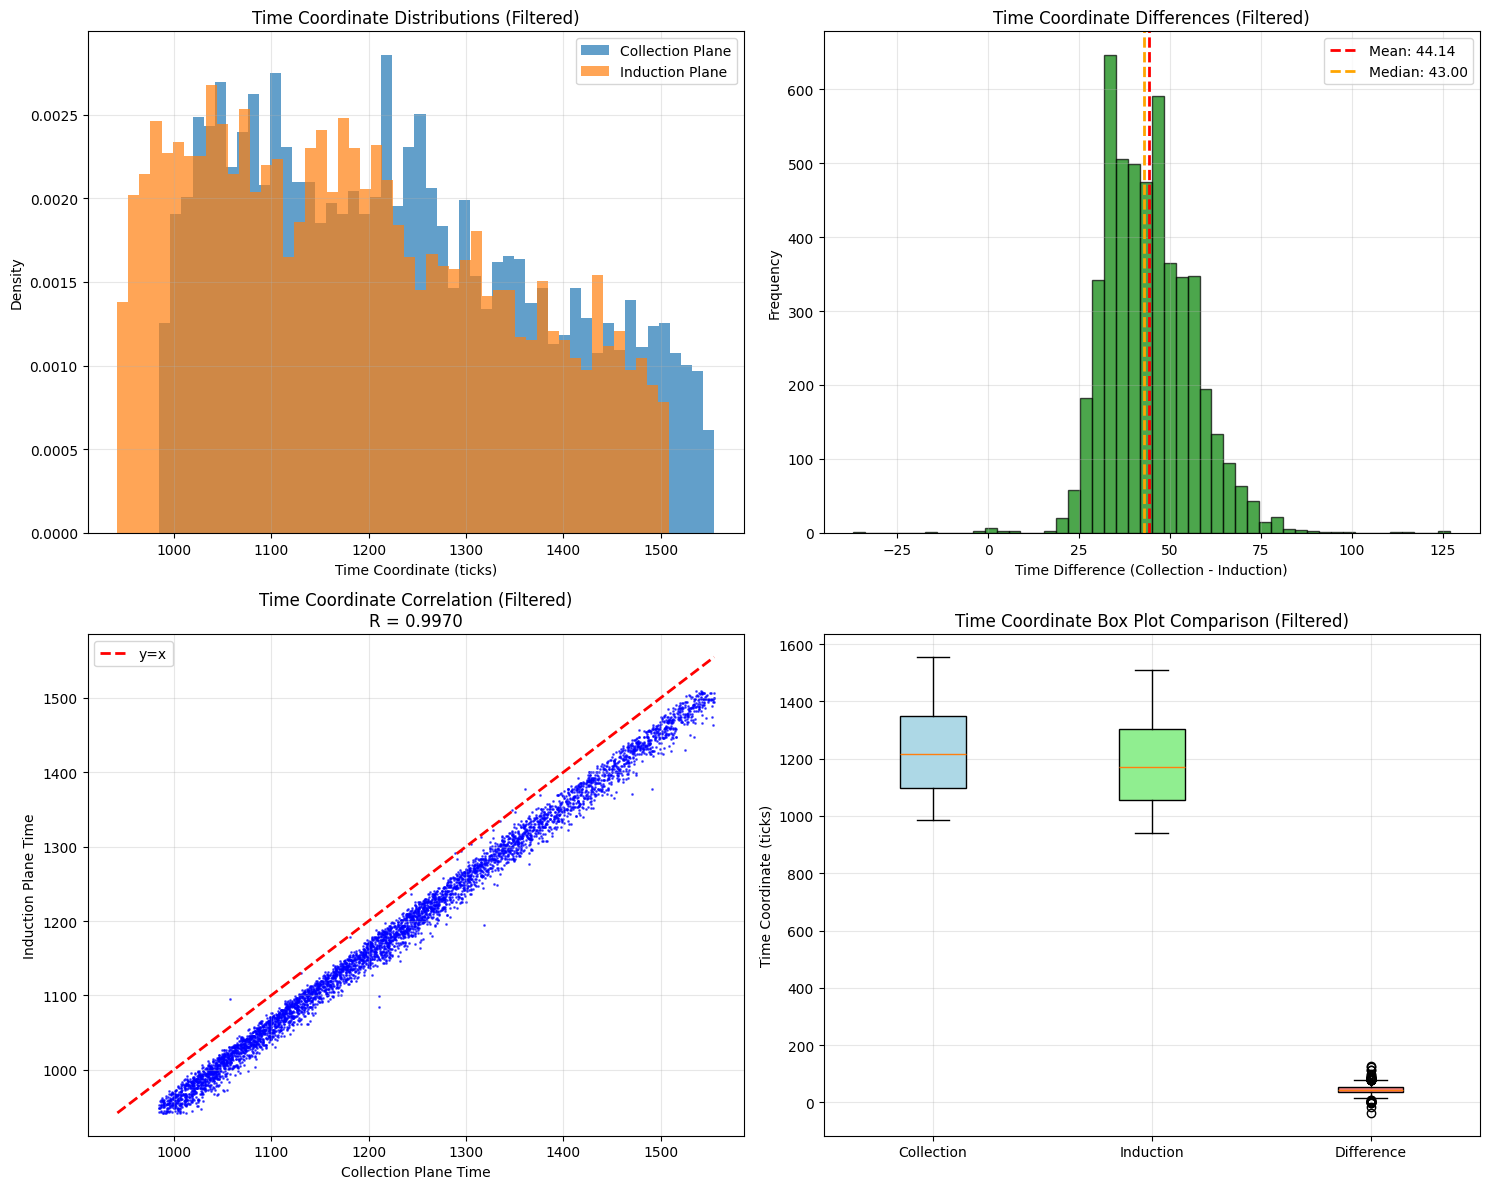

In [11]:
# Create comprehensive comparison plots for filtered data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Time distributions overlay
axes[0, 0].hist(col_time_filtered, bins=50, alpha=0.7, label='Collection Plane', density=True)
axes[0, 0].hist(ind_time_filtered, bins=50, alpha=0.7, label='Induction Plane', density=True)
axes[0, 0].set_xlabel('Time Coordinate (ticks)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Time Coordinate Distributions (Filtered)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Time difference histogram
axes[0, 1].hist(time_diff_filtered, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Time Difference (Collection - Induction)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Time Coordinate Differences (Filtered)')
axes[0, 1].axvline(stats_filtered['mean_diff'], color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {stats_filtered["mean_diff"]:.2f}')
axes[0, 1].axvline(stats_filtered['median_diff'], color='orange', linestyle='--', linewidth=2,
                   label=f'Median: {stats_filtered["median_diff"]:.2f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Scatter plot of time coordinates with correlation
axes[1, 0].scatter(col_time_filtered, ind_time_filtered, s=1, alpha=0.6, color='blue')
axes[1, 0].plot([min(col_time_filtered.min(), ind_time_filtered.min()), 
                 max(col_time_filtered.max(), ind_time_filtered.max())], 
                [min(col_time_filtered.min(), ind_time_filtered.min()), 
                 max(col_time_filtered.max(), ind_time_filtered.max())], 
                'r--', linewidth=2, label='y=x')
correlation = np.corrcoef(col_time_filtered, ind_time_filtered)[0, 1]
axes[1, 0].set_xlabel('Collection Plane Time')
axes[1, 0].set_ylabel('Induction Plane Time')
axes[1, 0].set_title(f'Time Coordinate Correlation (Filtered)\nR = {correlation:.4f}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Box plot and violin plot comparison
box_data_filtered = [col_time_filtered, ind_time_filtered, time_diff_filtered]
bp = axes[1, 1].boxplot(box_data_filtered, labels=['Collection', 'Induction', 'Difference'], 
                        patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1, 1].set_ylabel('Time Coordinate (ticks)')
axes[1, 1].set_title('Time Coordinate Box Plot Comparison (Filtered)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Find line of best fit with gradient = 1 (y = x + c)
# This means we need to find the optimal y-intercept (c) for the line y = x + c

# For a line y = x + c, the residuals are (ind_time - col_time - c)
# To minimize sum of squared residuals, we take the mean of (ind_time - col_time)
optimal_intercept = np.mean(ind_time_filtered - col_time_filtered)

print(f"Line of best fit with gradient = 1:")
print(f"Equation: induction_time = collection_time + {optimal_intercept:.2f}")
print(f"Or: induction_time = collection_time + ({optimal_intercept:.2f})")

# Calculate R-squared for this constrained fit
predicted_ind_time = col_time_filtered + optimal_intercept
ss_res = np.sum((ind_time_filtered - predicted_ind_time) ** 2)
ss_tot = np.sum((ind_time_filtered - np.mean(ind_time_filtered)) ** 2)
r_squared_constrained = 1 - (ss_res / ss_tot)

print(f"R-squared (constrained fit): {r_squared_constrained:.4f}")

# For comparison, calculate unconstrained linear regression
from scipy import stats as scipy_stats
slope, intercept, r_value, p_value, std_err = scipy_stats.linregress(col_time_filtered, ind_time_filtered)
print(f"\nFor comparison - unconstrained fit:")
print(f"Slope: {slope:.4f}")
print(f"Intercept: {intercept:.2f}")
print(f"R-squared (unconstrained): {r_value**2:.4f}")

Line of best fit with gradient = 1:
Equation: induction_time = collection_time + -44.14
Or: induction_time = collection_time + (-44.14)
R-squared (constrained fit): 0.9939

For comparison - unconstrained fit:
Slope: 0.9895
Intercept: -31.26
R-squared (unconstrained): 0.9941


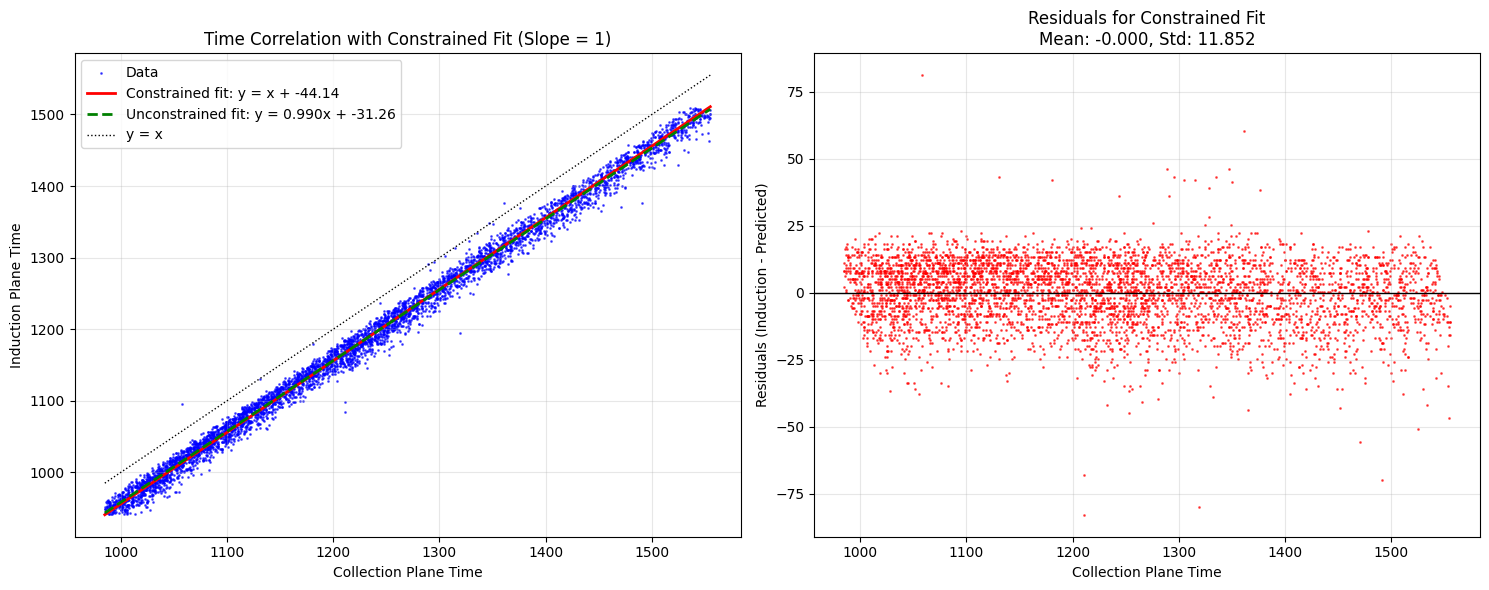

In [13]:
# Plot the constrained fit
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Scatter plot with both fits
axes[0].scatter(col_time_filtered, ind_time_filtered, s=1, alpha=0.6, color='blue', label='Data')

# Constrained fit (slope = 1)
x_range = np.array([col_time_filtered.min(), col_time_filtered.max()])
y_constrained = x_range + optimal_intercept
axes[0].plot(x_range, y_constrained, 'r-', linewidth=2, 
             label=f'Constrained fit: y = x + {optimal_intercept:.2f}')

# Unconstrained fit
y_unconstrained = slope * x_range + intercept
axes[0].plot(x_range, y_unconstrained, 'g--', linewidth=2, 
             label=f'Unconstrained fit: y = {slope:.3f}x + {intercept:.2f}')

# Perfect correlation line
axes[0].plot(x_range, x_range, 'k:', linewidth=1, label='y = x')

axes[0].set_xlabel('Collection Plane Time')
axes[0].set_ylabel('Induction Plane Time')
axes[0].set_title('Time Correlation with Constrained Fit (Slope = 1)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals for constrained fit
residuals_constrained = ind_time_filtered - (col_time_filtered + optimal_intercept)
axes[1].scatter(col_time_filtered, residuals_constrained, s=1, alpha=0.6, color='red')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_xlabel('Collection Plane Time')
axes[1].set_ylabel('Residuals (Induction - Predicted)')
axes[1].set_title(f'Residuals for Constrained Fit\nMean: {np.mean(residuals_constrained):.3f}, Std: {np.std(residuals_constrained):.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

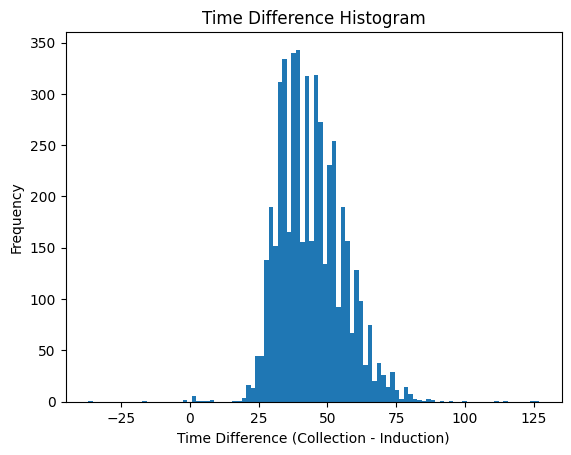

In [14]:
plt.hist(col_time_filtered - ind_time_filtered, bins=100)
plt.xlabel('Time Difference (Collection - Induction)')
plt.ylabel('Frequency')
plt.title('Time Difference Histogram')
plt.show()

In [15]:
# Calculate time coordinate differences for filtered data
wire_diff_filtered = col_wire_filtered - ind_wire_filtered

# Calculate statistics for filtered data
stats_filtered = {
    'mean_diff': np.mean(wire_diff_filtered),
    'std_diff': np.std(wire_diff_filtered),
    'median_diff': np.median(wire_diff_filtered),
    'min_diff': np.min(wire_diff_filtered),
    'max_diff': np.max(wire_diff_filtered),
    'q25_diff': np.percentile(wire_diff_filtered, 25),
    'q75_diff': np.percentile(wire_diff_filtered, 75),
    'iqr': np.percentile(wire_diff_filtered, 75) - np.percentile(wire_diff_filtered, 25)
}

print("Time Coordinate Differences (Collection - Induction) - Filtered Data:")
print(f"Mean: {stats_filtered['mean_diff']:.2f}")
print(f"Std Dev: {stats_filtered['std_diff']:.2f}")
print(f"Median: {stats_filtered['median_diff']:.2f}")
print(f"Min: {stats_filtered['min_diff']:.2f}")
print(f"Max: {stats_filtered['max_diff']:.2f}")
print(f"25th percentile: {stats_filtered['q25_diff']:.2f}")
print(f"75th percentile: {stats_filtered['q75_diff']:.2f}")
print(f"IQR: {stats_filtered['iqr']:.2f}")
print(f"Number of points: {len(wire_diff_filtered)}")

Time Coordinate Differences (Collection - Induction) - Filtered Data:
Mean: 2.61
Std Dev: 9.08
Median: 3.00
Min: -14.00
Max: 18.00
25th percentile: -5.00
75th percentile: 11.00
IQR: 16.00
Number of points: 4978
